In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [9]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

from pyscipopt import SCIP_EVENTTYPE
from pyscipopt.scip import Event, Eventhdlr

from src.problem import get_model_scip

In [10]:
model = get_model_scip('../data/raw/97_9_0.json', timeout=10)

model.optimize()

presolving:
(round 1, fast)       150 del vars, 433 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1304 clqs
(round 2, fast)       152 del vars, 524 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1317 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver (8 rounds): 44 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     196 del vars, 524 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1299 clqs
(round 4, fast)       196 del vars, 577 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1299 clqs
(round 5, exhaustive) 196 del vars, 609 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1299 clqs
(round 6, exhaustive) 196 del vars, 609 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 4601 upgd conss, 0 impls, 1299 clqs
(round 

presolving:
(round 1, fast)       150 del vars, 433 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1304 clqs
(round 2, fast)       152 del vars, 524 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1317 clqs
   (0.0s) running MILP presolver
   (0.0s) MILP presolver (8 rounds): 44 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     196 del vars, 524 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1299 clqs
(round 4, fast)       196 del vars, 577 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1299 clqs
(round 5, exhaustive) 196 del vars, 609 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 0 upgd conss, 0 impls, 1299 clqs
(round 6, exhaustive) 196 del vars, 609 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 210 chg coeffs, 4601 upgd conss, 0 impls, 1299 clqs
(round 

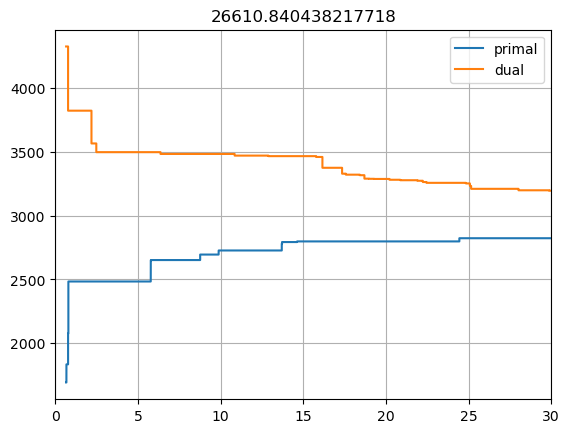

In [104]:
class PrimalDualIntegralHandler(Eventhdlr):
    def __init__(self, eventtypes=[SCIP_EVENTTYPE.NODESOLVED, SCIP_EVENTTYPE.BESTSOLFOUND], initial_primal=1e-20, initial_dual=1e4):
        self.eventtypes = eventtypes

        self._eventtype = 0
        for eventtype in self.eventtypes:
            self._eventtype |= eventtype

        self.primals = [initial_primal]
        self.duals = [initial_dual]
        self.times = [0]

        self.calls = list()

    def eventinit(self):
        self.model.catchEvent(self._eventtype, self)

    def eventexit(self):
        self.model.dropEvent(self._eventtype, self)

    def eventexec(self, event: Event):
        try:
            self.times.append(self.model.getTotalTime())
            self.primals.append(self.model.getPrimalbound())
            self.duals.append(self.model.getDualbound())
        except Exception:
            pass
    
    def get_primal_dual_integral(self):
        sense = 1 if self.model.getObjectiveSense() == 'minimze' else -1
        last_time = self.model.getTotalTime()

        integral = 0
        for i in range(1, len(self.times)):
            dt = self.times[i] - self.times[i-1]
            gap = sense * (self.primals[i-1] - self.duals[i-1])

            integral += dt * gap

        dt = last_time - self.times[-1]
        gap = sense * (self.primals[-1] - self.duals[-1])

        integral += dt * gap

        return integral

timeout = 30
model = get_model_scip('../data/raw/97_9_0.json', timeout=timeout, new_ineq=False)
# model.setParam('presolving/maxrounds', 0)

eventhdlr = PrimalDualIntegralHandler()
model.includeEventhdlr(eventhdlr, "Test", "test test")

model.optimize()

plt.step(eventhdlr.times[1:], eventhdlr.primals[1:], where='post', label='primal')
plt.step(eventhdlr.times[1:], eventhdlr.duals[1:], where='post', label='dual')
plt.xlim((0, timeout))
plt.title(eventhdlr.get_primal_dual_integral())
plt.legend()
plt.grid()
plt.show()

presolving:
(round 1, fast)       150 del vars, 943 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 623 chg coeffs, 0 upgd conss, 0 impls, 2645 clqs
(round 2, fast)       152 del vars, 1034 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 623 chg coeffs, 0 upgd conss, 0 impls, 2658 clqs
   (0.0s) running MILP presolver
   (0.1s) MILP presolver (8 rounds): 42 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     194 del vars, 1034 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 623 chg coeffs, 0 upgd conss, 0 impls, 2640 clqs
(round 4, fast)       194 del vars, 1085 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 1142 chg coeffs, 0 upgd conss, 0 impls, 2640 clqs
(round 5, exhaustive) 194 del vars, 1145 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 1142 chg coeffs, 0 upgd conss, 0 impls, 2640 clqs
(round 6, exhaustive) 194 del vars, 1145 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 1142 chg coeffs, 6576 upgd conss, 0 impls, 2640 clqs

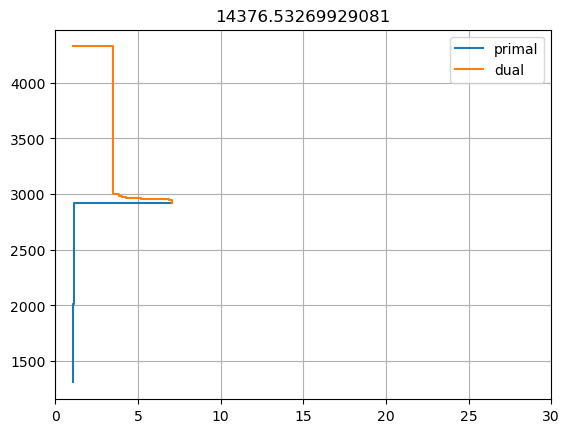

In [105]:
timeout = 30
model = get_model_scip('../data/raw/97_9_0.json', timeout=timeout, new_ineq=True)
# model.setParam('presolving/maxrounds', 0)

eventhdlr = PrimalDualIntegralHandler()
model.includeEventhdlr(eventhdlr, "Test", "test test")

model.optimize()

plt.step(eventhdlr.times[1:], eventhdlr.primals[1:], where='post', label='primal')
plt.step(eventhdlr.times[1:], eventhdlr.duals[1:], where='post', label='dual')
plt.xlim((0, timeout))
plt.title(eventhdlr.get_primal_dual_integral())
plt.legend()
plt.grid()
plt.show()

In [110]:
timeout = 30
model = get_model_scip('../data/raw/97_9_0.json', timeout=timeout, new_ineq=True, enable_primal_dual_integral=True)
# model.setParam('presolving/maxrounds', 0)

model.optimize()

model.get_primal_dual_integral()

presolving:
(round 1, fast)       150 del vars, 943 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 623 chg coeffs, 0 upgd conss, 0 impls, 2645 clqs
(round 2, fast)       152 del vars, 1034 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 623 chg coeffs, 0 upgd conss, 0 impls, 2658 clqs
   (0.0s) running MILP presolver
   (0.1s) MILP presolver (8 rounds): 42 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     194 del vars, 1034 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 623 chg coeffs, 0 upgd conss, 0 impls, 2640 clqs
(round 4, fast)       194 del vars, 1085 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 1142 chg coeffs, 0 upgd conss, 0 impls, 2640 clqs
(round 5, exhaustive) 194 del vars, 1145 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 1142 chg coeffs, 0 upgd conss, 0 impls, 2640 clqs
(round 6, exhaustive) 194 del vars, 1145 del conss, 0 add conss, 545 chg bounds, 210 chg sides, 1142 chg coeffs, 6576 upgd conss, 0 impls, 2640 clqs

14274.73817269806